# Deep Learning Models

A collection of deep learning models implemented on Pytorch for training purposes.

Author: Lucas Martinuzzo Batista<br>
GitHub: https://github.com/LucasMartinuzzo/Deep-Learning-Models

## AlexNet

Implementation of AlexNet, winner of 2012 ImageNet Competition.
Due to limited GPU technology at the time, the network was implemented using 2 GPUs and the work was divided among them, as showed in the piciture below.

![The Official Architecture of AlexNet](../../images/alexnet1.png)

Since GPUs have advanced since then, is not necessary to make this division anymore. So I  will implemented this version that merges the layers.

![The Implemented Architecture of AlexNet](../../images/alexnet2.png)

Paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import time

In [2]:
#Necessary to download CIFAR10
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = "cpu"
if torch.cuda.is_available():
    print("Cuda is Available!")
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

Cuda is Available!


### Dataset

In [4]:
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

I'll use the CIFAR 10 dataset, since the ImageNet dataset is no longer publicly accessible.

In [5]:
#transforms.ToTensor() normalizes the image from 0 - 255 to 0 - 1.
train_dataset = datasets.CIFAR10(root="../../data/",
                                      train=True,
                                      download=True,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize((227,227),interpolation=transforms.InterpolationMode.NEAREST)
                                      ])
                                )
test_dataset = datasets.CIFAR10(root="../../data/",
                                      train=False,
                                      download=False,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize((227,227),interpolation=transforms.InterpolationMode.NEAREST)
                                      ])
                                )

Files already downloaded and verified


In [6]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [7]:
print("Train size: ",train_size)
print("Test size: ",test_size)

Train size:  50000
Test size:  10000


In [8]:
train_loader = DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=TEST_BATCH_SIZE)

In [9]:
train_dataset[0][0].size()

torch.Size([3, 227, 227])

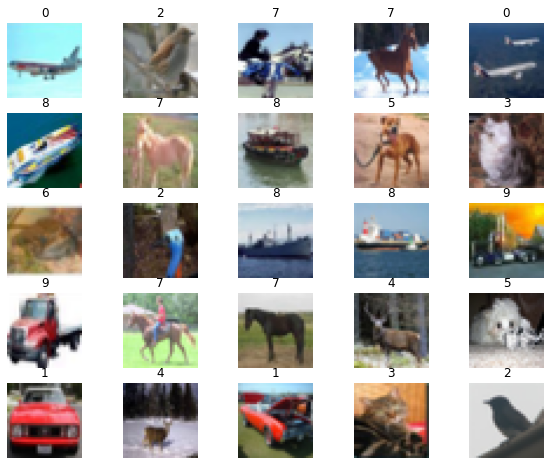

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

### Network

In [11]:
NUM_CLASSES = 10
RANDOM_SEED = 42

In [12]:
torch.manual_seed(RANDOM_SEED)

In [13]:
class AlexNet(nn.Module):
  #Constructor
    def __init__(self,num_classes):
        super(AlexNet,self).__init__()
        #Final size formula: (In_dim +2*padding - kernel_size)/stride + 1
        # 227x227x3 -> 55x55x96
        self.cv1 = nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4)
        self.lrn1 = nn.LocalResponseNorm(size=5,alpha=1e-4,beta=0.75,k=2)
        # 55x55x96 -> 27x27x96
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
        # 27x27x96 -> 27x27x256
        self.cv2 = nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
        self.lrn2 = nn.LocalResponseNorm(size=5,alpha=1e-4,beta=0.75,k=2)
        # 27x27x256 -> 13x13x256
        self.pool2  = nn.MaxPool2d(kernel_size=3,stride=2)
        # 13x13x256 -> 13x13x384
        self.cv3 = nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1)
        # 13x13x384 -> 13x13x384
        self.cv4 = nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1)
        # 13x13x384 -> 13x13x256
        self.cv5 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        # 13x13x256 -> 6x6x256
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=2)
        # 6x6x256 = 9216 -> 4096 
        self.fc6 = nn.Linear(in_features = 6*6*256, out_features=4096)
        # 4096 -> 4096
        self.fc7 = nn.Linear(in_features = 4096, out_features=4096)
        # 4096 -> 10 (NUM_CLASSES)
        self.out = nn.Linear(in_features = 4096, out_features=NUM_CLASSES)
        
        
    
    def forward(self,x):
        #The original paper uses TANH as activation function
        #But ReLU gives better results
        x = self.cv1(x)
        x = self.lrn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.cv2(x)
        x = self.lrn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.cv3(x)
        x = torch.relu(x)
        
        x = self.cv4(x)
        x = torch.relu(x)
        
        x = self.cv5(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = x.view(-1,6*6*256)
        x = self.fc6(x)
        x = nn.functional.dropout(x,p=0.5,training=self.training)
        x = torch.relu(x)
        
        x = self.fc7(x)
        x = nn.functional.dropout(x,p=0.5,training=self.training)
        x = torch.relu(x)
        
        logits = self.out(x)
        
        probs = nn.functional.log_softmax(logits,dim=1)
        
        return logits, probs

In [14]:
model = AlexNet(NUM_CLASSES)
model.to(device)

AlexNet(
  (cv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=9216, out_features=4096, bias=True)
  (fc7): Linear(in_features=4096, out_features=4096, bias=True)
  (out): Linear(in_features=4096, out_features=10, bias=True)
)

In [15]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
loss_criterion = nn.CrossEntropyLoss()

In [16]:
def train(model,optimizer,loss_function,train_loader,test_loader,epochs,train_size,test_size):
    LOSSES = []
    ACCURACIES = []
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        accumulated_loss = 0
        correct = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits,probs = model(x)
            loss = loss_function(logits,y)
            loss.backward()
            optimizer.step()
            accumulated_loss += loss.item()
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y).sum().item()
        LOSSES.append(accumulated_loss)
        train_accuracy = correct/train_size
        model.eval()
        correct = 0
        torch.cuda.empty_cache()
        for x_test,y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            logits,probs = model(x_test)
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y_test).sum().item()
        test_accuracy = correct/test_size
        print("Epoch {}/{}. Cost: {:.2f}. Train Accuracy: {:.2f}. Test Accuracy: {:.2f}".format(
                epoch+1,epochs,accumulated_loss,100*train_accuracy,100*test_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        ACCURACIES.append(test_accuracy)
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return LOSSES,ACCURACIES

In [17]:
LOSS, ACC = train(model,optimizer,loss_criterion,train_loader,test_loader,
                  epochs=20,train_size=train_size,test_size=test_size)

Epoch 1/20. Cost: 900.40. Train Accuracy: 9.89. Test Accuracy: 10.00
Time elapsed: 4.65 min
Epoch 2/20. Cost: 898.88. Train Accuracy: 11.10. Test Accuracy: 15.31
Time elapsed: 9.09 min
Epoch 3/20. Cost: 779.75. Train Accuracy: 25.64. Test Accuracy: 29.72
Time elapsed: 13.53 min
Epoch 4/20. Cost: 671.62. Train Accuracy: 36.23. Test Accuracy: 42.61
Time elapsed: 17.96 min
Epoch 5/20. Cost: 578.48. Train Accuracy: 45.66. Test Accuracy: 51.72
Time elapsed: 22.40 min
Epoch 6/20. Cost: 495.75. Train Accuracy: 53.98. Test Accuracy: 56.72
Time elapsed: 27.09 min
Epoch 7/20. Cost: 423.30. Train Accuracy: 61.35. Test Accuracy: 61.99
Time elapsed: 31.82 min
Epoch 8/20. Cost: 362.03. Train Accuracy: 67.48. Test Accuracy: 69.12
Time elapsed: 36.45 min
Epoch 9/20. Cost: 312.52. Train Accuracy: 71.94. Test Accuracy: 73.82
Time elapsed: 41.20 min
Epoch 10/20. Cost: 259.97. Train Accuracy: 76.84. Test Accuracy: 75.04
Time elapsed: 45.92 min
Epoch 11/20. Cost: 216.85. Train Accuracy: 80.54. Test Accurac

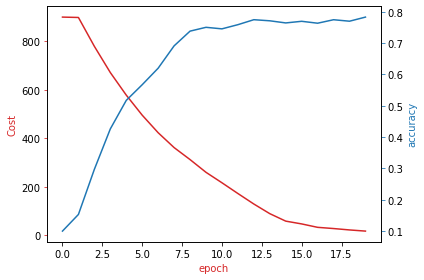

In [18]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( ACC, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()